# 가상 스크리닝


- 어떤 조건을 만족하는 분자를 찾아내는 작업을 화학 실험을 수행하지 않고 머신러닝 모델로 찾는 것을 말한다
- 여기서는 예제로 ERK2 단백질을 억제하는 분자를 선별하는 모델을 만든다
 - Extracellular signal-regulated kinase (다수의 생화학적 신호에 관여하고 세포의 증식 분화 전사조절에 관여)
 - 비소세포성 폐암 non-small cell lung cancer과 흑색종(피부암)에 대해 임상시험중

- 그래프 컨볼류션 모델을 사용한다

# import

In [1]:
!pip install DeepChem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 33.3 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1


In [2]:
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import rdmolops
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import rdMolDescriptors as rdmd
from deepchem.models import GraphConvModel


In [3]:
import numpy as np
import pandas as pd
import sys
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

# 데이터

- DUD-E 데이터베이스에서 활성 및 비활성 분자 데이터를 다운받아 사용한다
- 분자 데이터는 SMILES 로 표현되어 있으며 이를 데이터프레임에 불러온다
- AddMoleculeColumnToFrame()를 사용해 SMILES에 해당하는 Mol 객체를 데이터프레임에 추가할 수 있다

In [4]:
active_df = pd.read_csv("https://raw.githubusercontent.com/deepchem/DeepLearningLifeSciences/master/Chapter11/mk01/actives_final.ism",
                        header=None,sep=" ")
print(active_df.shape)
active_df[:3]

(79, 3)


,0,1,2
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,CHEMBL318804
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,CHEMBL162
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,CHEMBL576683


In [5]:
active_rows, active_cols = active_df.shape
active_df.columns = ["SMILES","ID","ChEMBL_ID"]
active_df["label"] = ["Active"]*active_rows
PandasTools.AddMoleculeColumnToFrame(active_df,"SMILES","Mol")

In [6]:
active_df[:3]

,SMILES,ID,ChEMBL_ID,label,Mol
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,CHEMBL318804,Active,<rdkit.Chem.rdchem.Mol object at 0x79c3b4b1d770>
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,CHEMBL162,Active,<rdkit.Chem.rdchem.Mol object at 0x79c3b4b1d1c0>
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,CHEMBL576683,Active,<rdkit.Chem.rdchem.Mol object at 0x79c3b4b1d460>


## 특성값 추가
- 분자량 molecular weight
- 분배 계수 partition coefficeint(LogP)
- 전하 charge (양인지 음인지)

In [7]:
def add_property_columns_to_df(df_in):
    df_in["mw"] = [Descriptors.MolWt(mol) for mol in df_in.Mol]
    df_in["logP"] = [Descriptors.MolLogP(mol) for mol in df_in.Mol]
    df_in["charge"] = [rdmolops.GetFormalCharge(mol) for mol in df_in.Mol]

In [8]:
add_property_columns_to_df(active_df)
active_df.head()

,SMILES,ID,ChEMBL_ID,label,Mol,mw,logP,charge
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,CHEMBL318804,Active,<rdkit.Chem.rdchem.Mol object at 0x79c3b4b1d770>,565.099,5.49788,0
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,CHEMBL162,Active,<rdkit.Chem.rdchem.Mol object at 0x79c3b4b1d1c0>,466.541,4.35400,0
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,CHEMBL576683,Active,<rdkit.Chem.rdchem.Mol object at 0x79c3b4b1d460>,527.915,4.96202,0
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,CHEMBL571484,Active,<rdkit.Chem.rdchem.Mol object at 0x79c3b4b1c350>,491.935,4.36922,0
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,CHEMBL568937,Active,<rdkit.Chem.rdchem.Mol object at 0x79c3b4b1d850>,487.991,5.12922,0


## 비활성화 데이터

In [9]:
decoy_df = pd.read_csv("https://raw.githubusercontent.com/deepchem/DeepLearningLifeSciences/master/Chapter11/mk01/decoys_final.ism",
                       header=None,sep=" ")
decoy_df.columns = ["SMILES","ID"]
decoy_rows, decoy_cols = decoy_df.shape
decoy_df["label"] = ["Decoy"]*decoy_rows
PandasTools.AddMoleculeColumnToFrame(decoy_df,"SMILES","Mol")
add_property_columns_to_df(decoy_df)

- 활성 및 비확성 데이터를 합친다

In [10]:
tmp_df = active_df.append(decoy_df)
tmp_df.shape

(4629, 8)

## 데이터 탐색

- violin plot

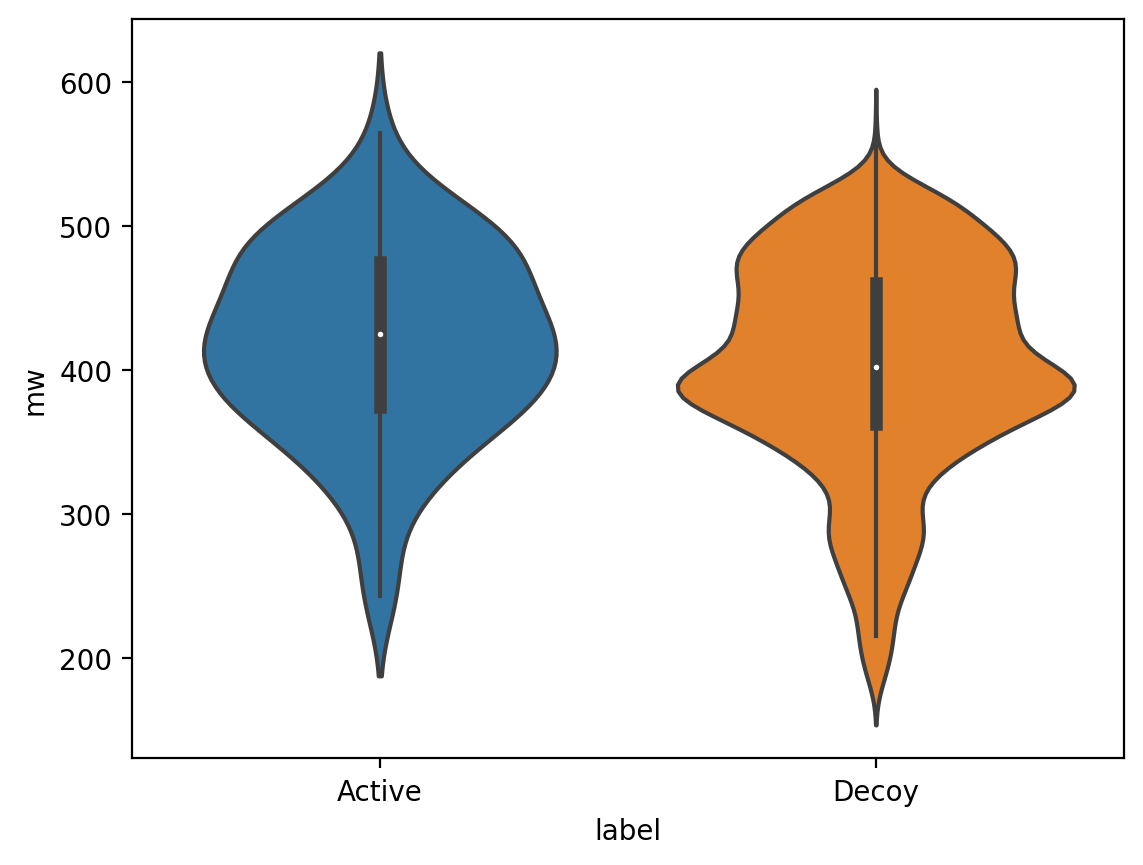

In [11]:
sns.violinplot(x=tmp_df["label"],y=tmp_df["mw"]);

- 위 그래프를 보면 분자량 분포는 비슷하다
- 400mw 이하의 분자들이 비활성 분자 데이터셋에 좀 더 많이 들어 있다

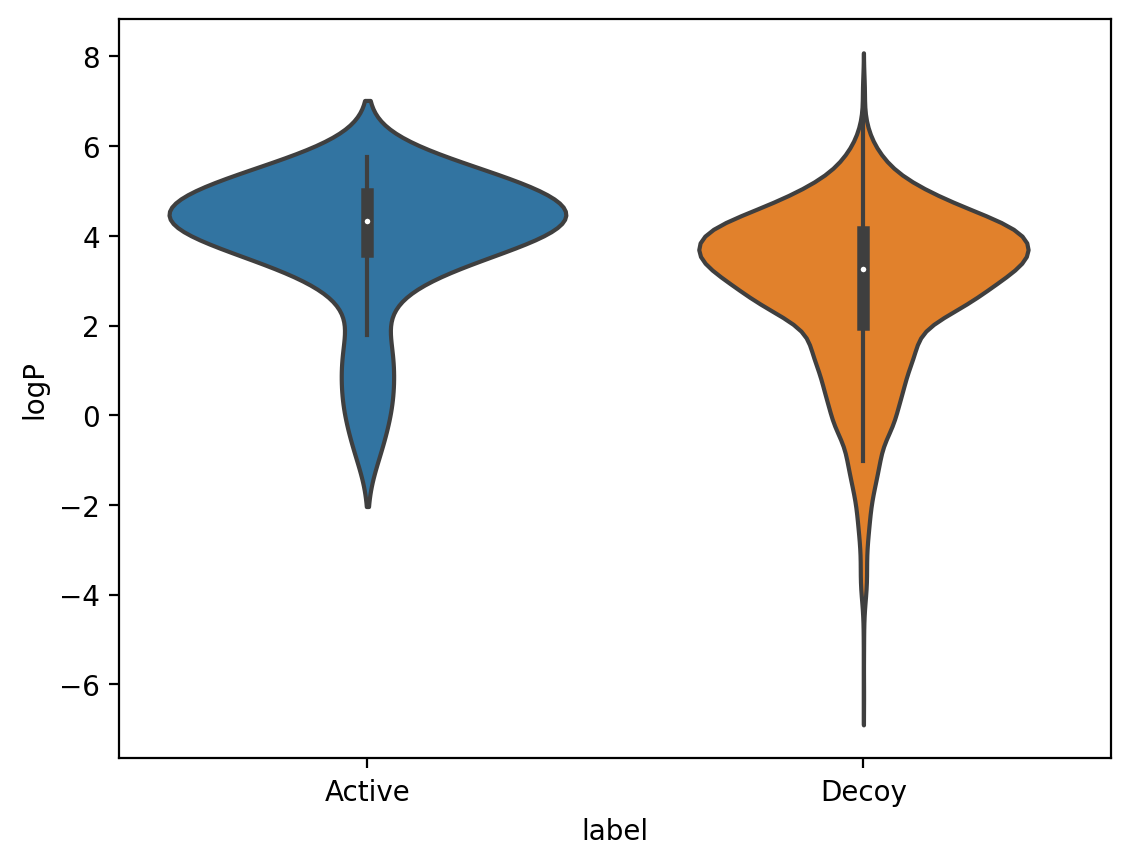

In [12]:
sns.violinplot(x=tmp_df["label"],y=tmp_df["logP"]);

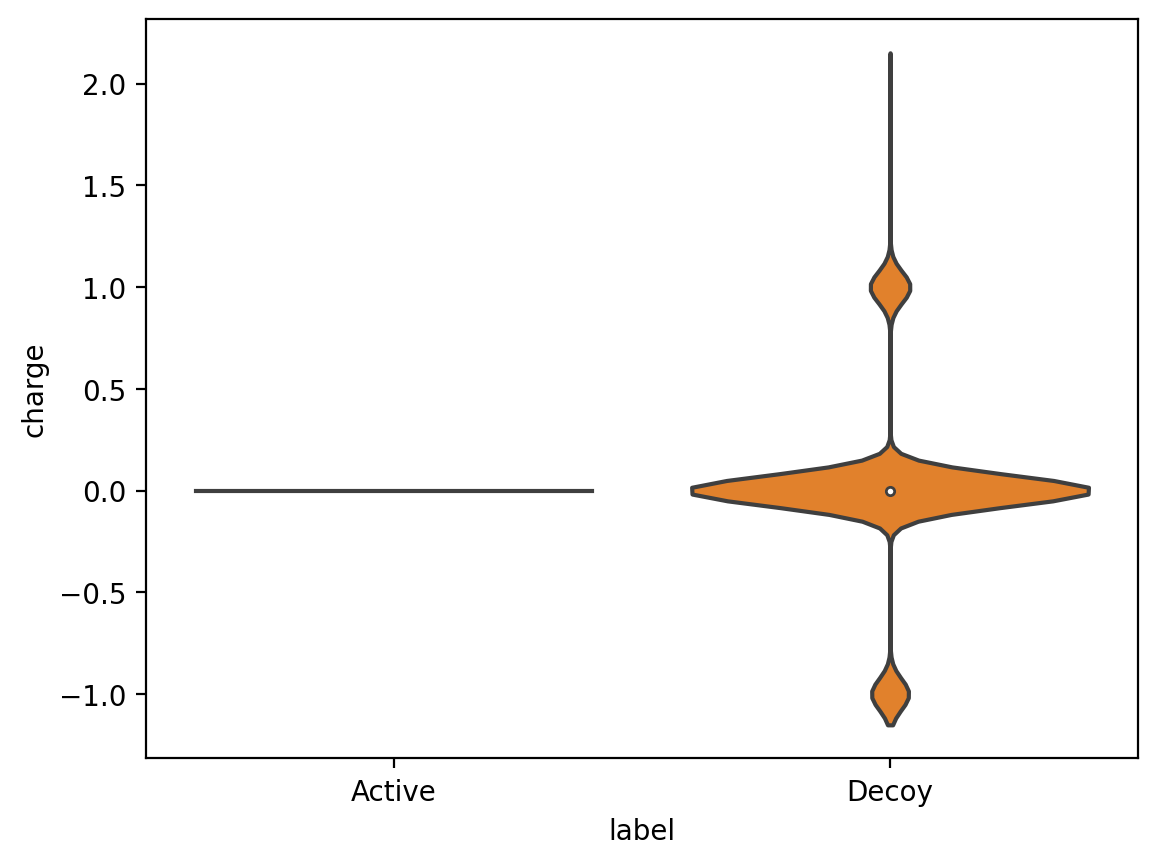

In [13]:
sns.violinplot(x=tmp_df["label"],y=tmp_df["charge"]);

- 활성 분자는 모두 중성이다
- 비활성 분자는 일부 +1과 -1이 있다

In [14]:
charged = decoy_df[decoy_df["charge"] != 0]
charged.shape[0]/decoy_df.shape[0]

0.16175824175824177

- 비활성 분자의 16%가 전하를 띠고 있다
- 전하 차이에 의해 머신러닝 모델이 바이어스가 생기게 되므로, 비활성 분자의 화학 구조를 수정하여 전하를 제거하겠다
- 아래는 이를 위한 함수 정의이다

In [15]:
def _InitialiseNeutralisationReactions():
    patts= (
        # Imidazoles
        ('[n+;H]','n'),
        # Amines
        ('[N+;!H0]','N'),
        # Carboxylic acids and alcohols
        ('[$([O-]);!$([O-][#7])]','O'),
        # Thiols
        ('[S-;X1]','S'),
        # Sulfonamides
        ('[$([N-;X2]S(=O)=O)]','N'),
        # Enamines
        ('[$([N-;X2][C,N]=C)]','N'),
        # Tetrazoles
        ('[n-]','[nH]'),
        # Sulfoxides
        ('[$([S-]=O)]','S'),
        # Amides
        ('[$([N-]C=O)]','N'),
        )
    return [(Chem.MolFromSmarts(x),Chem.MolFromSmiles(y,False)) for x,y in patts]

_reactions=None

def NeutraliseCharges(smiles, reactions=None):
    global _reactions
    if reactions is None:
        if _reactions is None:
            _reactions=_InitialiseNeutralisationReactions()
        reactions=_reactions
    mol = Chem.MolFromSmiles(smiles)
    replaced = False
    for i,(reactant, product) in enumerate(reactions):
        while mol.HasSubstructMatch(reactant):
            replaced = True
            rms = AllChem.ReplaceSubstructs(mol, reactant, product)
            mol = rms[0]
    if replaced:
        return (Chem.MolToSmiles(mol,True), True)
    else:
        return (smiles, False)

In [16]:
revised_decoy_df = decoy_df[["SMILES","ID","label"]].copy()

- 중성화된 SMILES는 첫 번째 컬럼에 들어 있다

In [17]:
revised_decoy_df["SMILES"] = [NeutraliseCharges(x)[0] for x in revised_decoy_df["SMILES"]]


In [18]:
revised_decoy_df.shape

(4550, 3)

- 특성을 다시 계산한다
- 전하를 띤 샘플의 수가 감소했다

In [19]:
PandasTools.AddMoleculeColumnToFrame(revised_decoy_df,"SMILES","Mol")
add_property_columns_to_df(revised_decoy_df)

In [20]:
new_tmp_df = active_df.append(revised_decoy_df)

<Axes: xlabel='label', ylabel='charge'>

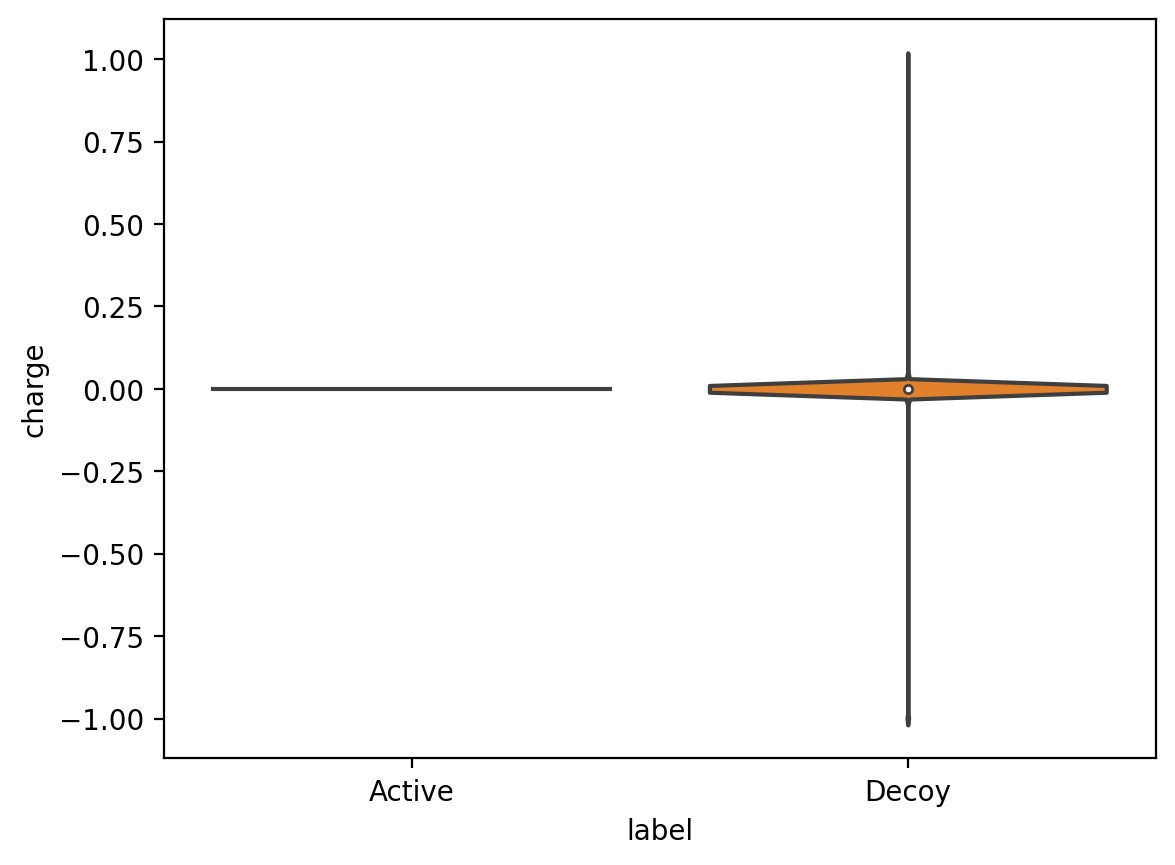

In [21]:
sns.violinplot(x=new_tmp_df["label"],y=new_tmp_df["charge"])

In [22]:
charged = revised_decoy_df[revised_decoy_df["charge"] != 0]
charged.shape[0]/revised_decoy_df.shape[0]

0.0026373626373626374

- 활성을 1로 비활성을 0으로 인코딩한다

In [23]:
active_df["is_active"] = [1] * active_df.shape[0]
revised_decoy_df["is_active"] = [0] * revised_decoy_df.shape[0]
combined_df = active_df.append(revised_decoy_df)[["SMILES","ID","is_active"]]
combined_df.head()

,SMILES,ID,is_active
0,Cn1ccnc1Sc2ccc(cc2Cl)Nc3c4cc(c(cc4ncc3C#N)OCCC...,168691,1
1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,86358,1
2,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575087,1
3,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575065,1
4,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...,575047,1


In [25]:
# 전처리한 데이터를 파일로 저장해둔다
combined_df.to_csv("dude_erk1_mk01.csv")

# 분류 모델

- GCN 모델을 사용한다

##  그래프 컨볼류션 모델 생성

In [26]:
def generate_graph_conv_model():
    batch_size = 128
    model = GraphConvModel(1, batch_size=batch_size,
             mode='classification', model_dir="./model_dir")
    return model

In [27]:
dataset_file = "dude_erk1_mk01.csv"
tasks = ["is_active"]
featurizer = dc.feat.ConvMolFeaturizer()
loader = dc.data.CSVLoader(tasks=tasks, feature_field="SMILES", featurizer=featurizer)
dataset = loader.create_dataset(dataset_file, shard_size=8192)

- RandomSplitter() 사용 - 데이터를 래덤하게 나눈다
- 화학 구조를 기반으로 데이터셋을 나누는 ScaffoleSplit(), 데이터를 군집화 한 후에 데이터셋을 나누는 ButinaSplitter()도 있다
- 불균형 데이터에 대한 성능 평가시에는 매튜 상관계수 Matthews Correlarions Coefficients(MCC)를 사용한다
 - +1이면 완벽한 예측, 0이면 랜덤 예측, -1이면 완전히 반대되는 예측을 의미한다
- 모델을 5회 만들어 평균을 구한다 (랜덤 교차검증)

In [28]:
splitter = dc.splits.RandomSplitter()
metrics = [dc.metrics.Metric(dc.metrics.matthews_corrcoef, np.mean)]

In [29]:
training_score_list = []
validation_score_list = []
transformers = []
cv_folds = 5
for i in tqdm(range(0,cv_folds)):
    model = generate_graph_conv_model()
    train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(dataset)
    model.fit(train_dataset)
    train_scores = model.evaluate(train_dataset, metrics, transformers)
    training_score_list.append(train_scores["mean-matthews_corrcoef"])
    validation_scores = model.evaluate(valid_dataset, metrics, transformers)
    validation_score_list.append(validation_scores["mean-matthews_corrcoef"])
print(training_score_list)
print(validation_score_list)

  0%|          | 0/5 [00:00<?, ?it/s]

[0.6411635129765872, 0.6370436559461252, 0.8803382869037676, 0.17669972450070826, 0.8977422841329967]
[0.8641283031407085, 0.814715779285453, 0.8934523381859952, 0.574840038738937, 0.8650835596735099]


In [31]:
np.array(training_score_list).mean(), np.array(validation_score_list).mean()

(0.646597492892037, 0.8024440038049206)

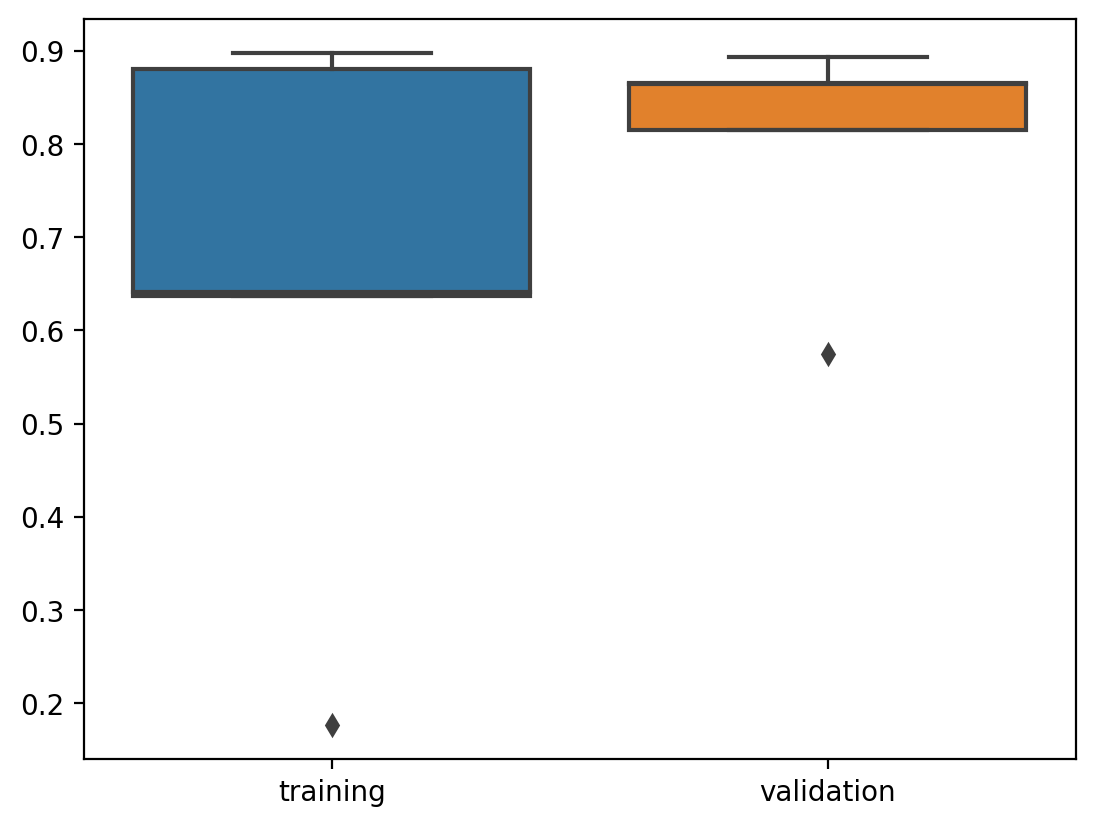

In [32]:
sns.boxplot(x=["training"]*cv_folds+["validation"]*cv_folds,y=training_score_list+validation_score_list);

## 검증 데이터 분류 예측

In [33]:
pred = [x.flatten() for x in model.predict(valid_dataset)]
pred[:3]

[array([0.95733374, 0.0426663 ], dtype=float32),
 array([0.9898094 , 0.01019065], dtype=float32),
 array([0.9989889 , 0.00101109], dtype=float32)]

In [34]:
pred_df = pd.DataFrame(pred,columns=["neg","pos"])
pred_df["active"] = [int(x) for x in valid_dataset.y]
pred_df["SMILES"] = valid_dataset.ids
pred_df.head()

,neg,pos,active,SMILES
0,0.957334,0.042666,0,Cc1c2c([nH]c1C(=O)NCCN3c4ccccc4N[C@@H]3C)CCCC2=O
1,0.989809,0.010191,0,C1CCC(CC1)CC(=O)NNC(=O)c2c(c(n[nH]2)C3CC3)Br
2,0.998989,0.001011,0,C[C@]12CC/C(=N/OCC(=O)NCCc3ccc(cc3)O)/C=C1CC[C...
3,0.999276,0.000724,0,C[C@@H]1[C@H](CC[C@]2([C@H]1[C@H]([C@H](CC2)[C...
4,0.980175,0.019825,0,C/C(=C/C(=O)Nc1ccccc1)/NNC(=O)c2cc(ccc2O)Br


In [35]:
pred_df.sort_values("pos",ascending=False).head(5)

,neg,pos,active,SMILES
89,0.020704,0.979296,1,Cc1cnc(nc1c2cc([nH]c2)C(=O)N[C@H](CO)c3cccc(c3...
61,0.199121,0.800879,1,c1ccc2c(c1)CCN(C2)C(=O)c3cc(c[nH]3)c4c(cn[nH]4...
388,0.470208,0.529792,1,COc1cc2c(cc1OCCCN3CCOCC3)ncc(c2Nc4ccc(cc4)Oc5c...
163,0.744927,0.255073,0,c1cc2c(cc1C#N)nc([nH]2)[C@@H]([C@H](c3[nH]c4cc...
228,0.768229,0.231771,0,C1COCCNC(=S)NCCOCCOCCNC(=S)N1


<Axes: xlabel='active', ylabel='pos'>

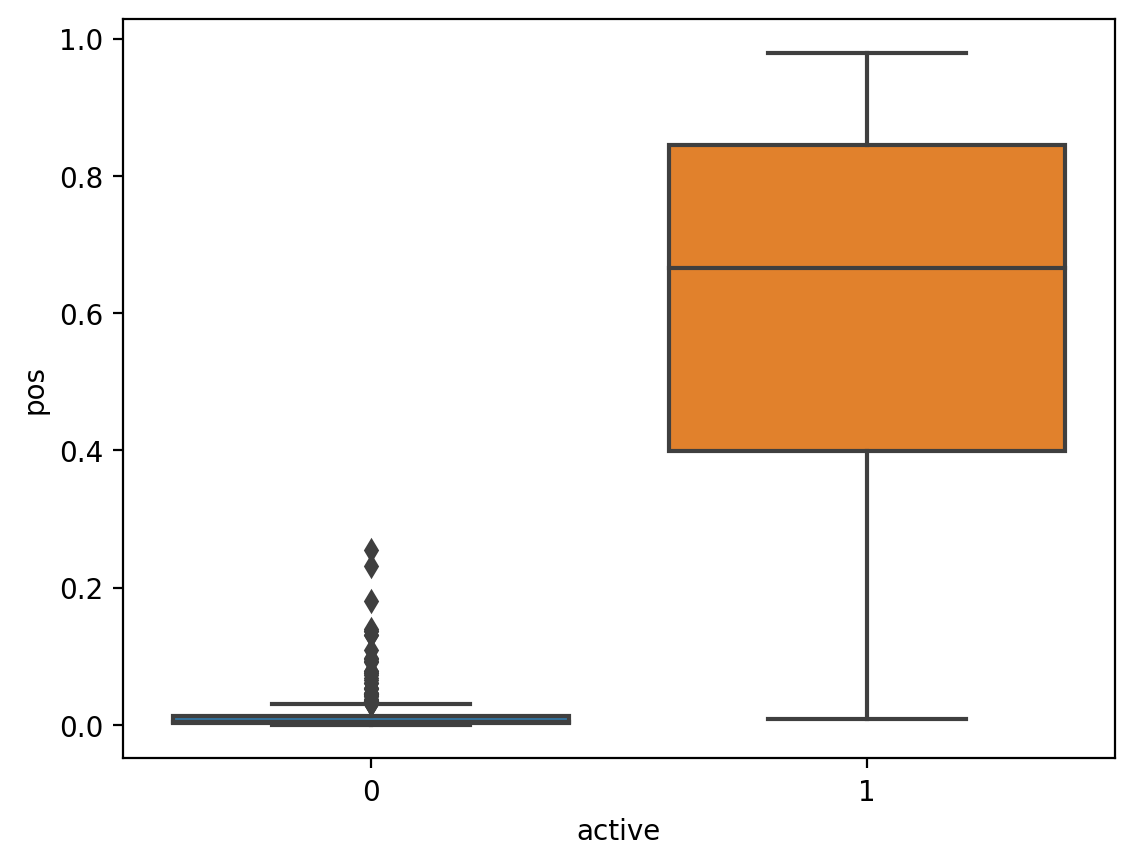

In [37]:
sns.boxplot(x=pred_df.active,y=pred_df.pos)

- 위 그래프를 보면 활성 분자와 비활성 분자를 잘 구분하고 있는 것을 알 수 있다
- False Negative 샘플 찾기

In [38]:
false_negative_df = pred_df.query("active == 1 & pos < 0.5").copy()

,neg,pos,active,SMILES,Mol
314,0.990996,0.009004,1,C[C@@]12[C@@H]([C@@H](CC(O1)n3c4ccccc4c5c3c6n2...,

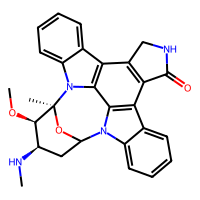

In [39]:
PandasTools.AddMoleculeColumnToFrame(false_negative_df,"SMILES","Mol")
false_negative_df

- False Positive 샘플 찾기

In [40]:
false_positive_df = pred_df.query("active == 0 & pos > 0.5").copy()
PandasTools.AddMoleculeColumnToFrame(false_positive_df,"SMILES","Mol")
false_positive_df

,neg,pos,active,SMILES,Mol


## 모든 데이터로 학습
- 모델의 성능을 향상시키기 위해서 검증데이터를 훈련에 사용

In [41]:
model.fit(dataset)

0.0009412271281083425

- 앞에서 ERK2 단백질의 활성을 억제하는 분자를 예측하는 모델을 만들었다. 여기에 새로운 데이터셋을 사용하여 분자의 활성을 예측해보겠다
 - ZINC 데이터베이스의 일부를 사용하겠다

## rd_filters 적용

- Pat Walters가 만든 스크립트로 잠재적으로 문제가 있는 분자를 걸러낸다
- 생물학적 분석이 어려운 분자들을 제거하기 위해서 rd_filters.py를 사용
- [rd_filters github](https://github.com/PatWalters/rd_filters)

In [42]:
# 현재 폴더에 해당 git 설치
!pip install git+https://github.com/PatWalters/rd_filters.git

  Cloning https://github.com/PatWalters/rd_filters.git to /tmp/pip-req-build-_em08v8r
  Running command git clone --filter=blob:none --quiet https://github.com/PatWalters/rd_filters.git /tmp/pip-req-build-_em08v8r
  Resolved https://github.com/PatWalters/rd_filters.git to commit 3630f1a59150b4a203c2f06d8376a66d1d4c3f70
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for rd-filters: filename=rd_filters-0.1-py3-none-any.whl size=33863 sha256=709b110cef640b614eca145df3289162f653a44bcc88d16c07503e19a058892a
  Stored in directory: /tmp/pip-ephem-wheel-cache-nfhq58gi/wheels/1d/57/d3/243da16d0396df21d623d6c41bcae207900be0f3f1a4e3224f
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=0692b0c10a9105baee46a523db9474814cbb7e6a2b52c292dc43c8d26c533e4a
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built rd-filters docopt


In [43]:
# 사용법 안내
!rd_filters -h

Usage:
rd_filters filter --in INPUT_FILE --prefix PREFIX [--rules RULES_FILE_NAME] [--alerts ALERT_FILE_NAME][--np NUM_CORES]
rd_filters template --out TEMPLATE_FILE [--rules RULES_FILE_NAME]

Options:
--in INPUT_FILE input file name
--prefix PREFIX prefix for output file names
--rules RULES_FILE_NAME name of the rules JSON file
--alerts ALERTS_FILE_NAME name of the structural alerts file
--np NUM_CORES the number of cpu cores to use (default is all)
--out TEMPLATE_FILE parameter template file name


## Zink 데이터에 필터 적용
- 100k 데이터 다운로드

In [45]:
!curl -o zinc_100k.smi https://raw.githubusercontent.com/deepchem/DeepLearningLifeSciences/master/Chapter11/zinc_100k.smi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6159k  100 6159k    0     0  29.5M      0 --:--:-- --:--:-- --:--:-- 29.6M


- 필터 수행
 - 필터 수행 결과 68.4%가 통과하였다
 - 생물학적 분석이 어려운 화합물을 제거
 - 필터 결과는 zinc.csv에 저장된다. 필터를 통과한 SMILES 정보는 zinc.smi에 저장된다

In [46]:
!rd_filters filter --in zinc_100k.smi --prefix zinc

using 2 cores
Using alerts from Inpharmatica
Wrote SMILES for molecules passing filters to zinc.smi
Wrote detailed data to zinc.csv
67885 of 100000 passed filters 67.9%
Elapsed time 111.30 seconds


## 필터 결과

- zinc.csv의 내용
 - SMILES 문자열,
 - 분자의 이름(NAME),
 - 필터를 통과하지 못한 이유(FILTER),
 - 분자량(MW, 500보다 크면 통과하지 못한다),
 - 옥탄올/물 분배계수(LogP, 5보다 크면 통과하지 못한다)
 - 수소결합의 공여체수 (HBD)

In [47]:
df = pd.read_csv("zinc.csv")
df.head()

,SMILES,NAME,FILTER,MW,LogP,HBD,HBA,TPSA,Rot
0,CN(CCO)C[C@@H](O)Cn1cnc2c1c(=O)n(C)c(=O)n2C,ZINC000000000843,Filter82_pyridinium > 0,311.342,-2.2813,2,9,105.52,6
1,O=c1[nH]c(=O)n([C@@H]2C[C@@H](O)[C@H](CO)O2)cc1Br,ZINC000000001063,Filter82_pyridinium > 0,307.100,-1.0602,3,6,104.55,2
2,Cn1c2ncn(CC(=O)N3CCOCC3)c2c(=O)n(C)c1=O,ZINC000000003942,Filter82_pyridinium > 0,307.310,-1.7075,0,8,91.36,2
3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,OK,308.382,-1.0163,0,5,64.17,3
4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,OK,302.327,-1.1355,3,6,106.12,4


- FILTER의 경우의 수를 파악하기 위해서 collection의 Counter를 사용한다
 - 통과한 수(OK)는 69148이다
 - 1,2 디카르보닐 구조를 포하여 통과하지 못한 경우는 19330이다 (이는 아미노산 셀린 또는 시스테인과 공유결합을 형성하는 것으로 알려져 있다)
 - filter_collection.CSV 파일을 보면 1,2디카르보닐 구조를 의미하는 SMARTS 문자열'*C(=O)C(=O)*'를 확인할 수 있다.

In [48]:
from collections import Counter
count_list = list(Counter(df.FILTER).items())
count_df = pd.DataFrame(count_list,columns=["Rule","Count"])
count_df.sort_values("Count",inplace=True,ascending=False)
count_df.head()

,Rule,Count
1,OK,68611
6,Filter41_12_dicarbonyl > 0,19330
0,Filter82_pyridinium > 0,7544
9,Filter93_acetyl_urea > 0,1541
10,Filter78_bicyclic_Imide > 0,825


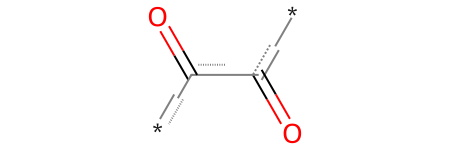

In [50]:
dicarbonyl = Chem.MolFromSmarts('*C(=O)C(=O)*')
dicarbonyl

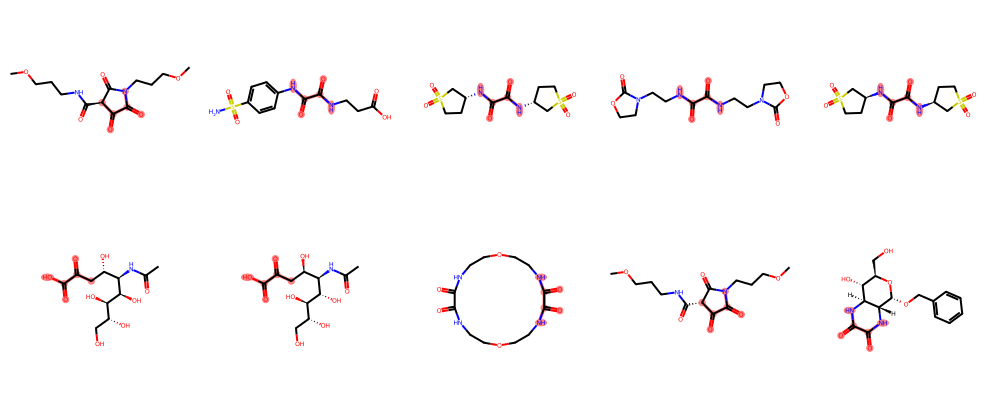

In [51]:
smiles_list = df[df.FILTER == "Filter41_12_dicarbonyl > 0"].SMILES[:10]
mol_list = [Chem.MolFromSmiles(x) for x in smiles_list]
match_list = [mol.GetSubstructMatch(dicarbonyl) for mol in mol_list]
Draw.MolsToGridImage(mol_list,highlightAtomLists=match_list,molsPerRow=5)

# 모델 사용하기
- GCN 모델을 불러오고, 피처화기를 만든후, 분자 데이터를 피처화 한다
- 예측값을 확인하고 가장 높은 점수를 얻은 화학구조를 확인한다
- 분자 데이터를 CSV로 저장한다

In [52]:
# 저장된 모델 불러오기
# model = dc.models.GraphConvModel(1, batch_size=128,
#           mode='classification',model_dir="model_dir")
# model.restore()

In [54]:
df = pd.read_csv("zinc_100k.smi",sep=" ",header=None)
df.columns=["SMILES","Name"]
rows,cols = df.shape
df["Val"] = [0] * rows # 피처화를 위한 빈 자리
df.head()

,SMILES,Name,Val
0,CN(CCO)C[C@@H](O)Cn1cnc2c1c(=O)n(C)c(=O)n2C,ZINC000000000843,0
1,O=c1[nH]c(=O)n([C@@H]2C[C@@H](O)[C@H](CO)O2)cc1Br,ZINC000000001063,0
2,Cn1c2ncn(CC(=O)N3CCOCC3)c2c(=O)n(C)c1=O,ZINC000000003942,0
3,CN1C(=O)C[C@H](N2CCN(C(=O)CN3CCCC3)CC2)C1=O,ZINC000000036436,0
4,CC(=O)NC[C@H](O)[C@H]1O[C@H]2OC(C)(C)O[C@H]2[C...,ZINC000000041101,0


In [55]:
infile_name = "zinc_filtered.csv"
df.to_csv(infile_name,index=False)

- CSV 파일을 읽어온다
- dataset을 만든후 모델을 사용하기 위해서 피처화를 수행한다
 - ConvMolFeaturizer 사용
- 시간이 오래걸린다 (7분)

In [56]:
loader = dc.data.CSVLoader(tasks=['Val'], feature_field="SMILES", featurizer=featurizer)
dataset = loader.create_dataset(infile_name, shard_size=8192)
pred = model.predict(dataset)

- 활성화와 비활성화를 구분하기 위해서 점수를 시각화 한다
- SMILES와 예측값이 있는 데이터프레임을 합친다
- 예측값이 높은 분자를 살펴본다
 - 아래 그림에서 0.3 이상을 선택하겠다

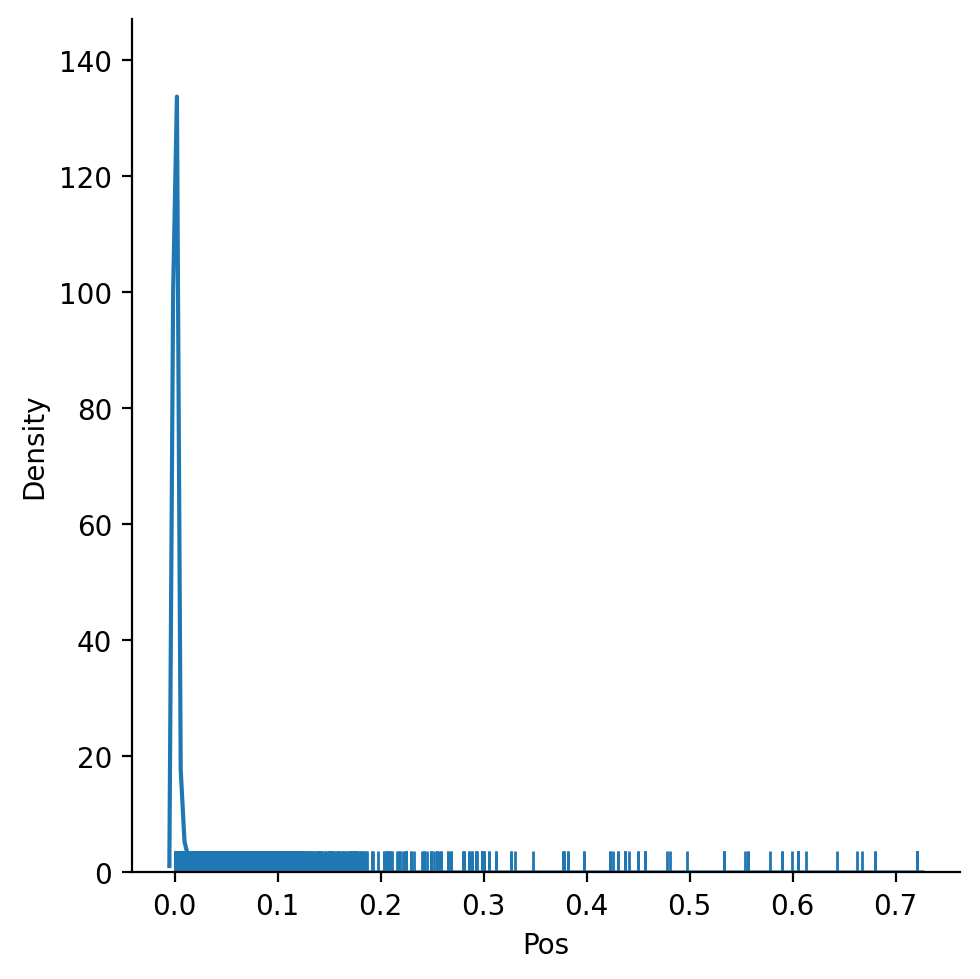

In [57]:
pred_df = pd.DataFrame([x.flatten() for x in pred],columns=["Neg","Pos"])
sns.displot(x=pred_df.Pos,kind="kde",rug=True)


In [58]:
combo_df = df.join(pred_df,how="outer")
combo_df.sort_values("Pos",inplace=True,ascending=False)

In [59]:
PandasTools.AddMoleculeColumnToFrame(combo_df,"SMILES","Mol")
combo_df.head()

,SMILES,Name,Val,Neg,Pos,Mol
1998,OCCNc1ncnc2c1ncn2[C@H]1O[C@@H](CO)[C@@H](O)[C@...,ZINC000004722772,0,0.278743,0.721257,<rdkit.Chem.rdchem.Mol object at 0x79c2ac6dd0e0>
2000,OCCNc1ncnc2c1ncn2[C@@H]1O[C@@H](CO)[C@@H](O)[C...,ZINC000004722774,0,0.278743,0.721257,<rdkit.Chem.rdchem.Mol object at 0x79c2ac6dd230>
1999,OCCNc1ncnc2c1ncn2[C@@H]1O[C@@H](CO)[C@@H](O)[C...,ZINC000004722773,0,0.278744,0.721256,<rdkit.Chem.rdchem.Mol object at 0x79c2ac6dd2a0>
1819,OCCNc1ncnc2c1ncn2[C@H]1O[C@@H](CO)[C@@H](O)[C@...,ZINC000001685071,0,0.278744,0.721256,<rdkit.Chem.rdchem.Mol object at 0x79c2ac6dd380>
309,OCCNc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@...,ZINC000006119248,0,0.278744,0.721256,<rdkit.Chem.rdchem.Mol object at 0x79c2ac6dd460>


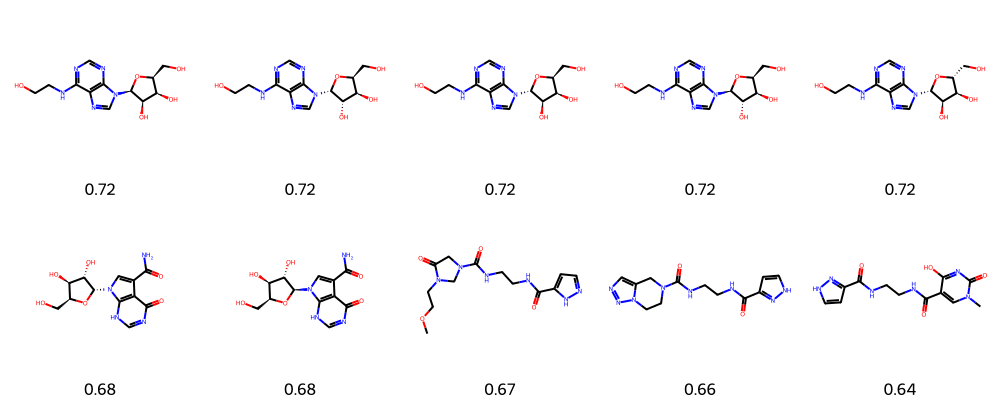

In [60]:
Draw.MolsToGridImage(combo_df.Mol[:10],molsPerRow=5,legends=["%.2f" % x for x in combo_df.Pos[:10]])


- 예측값이 높는 분자들의 모양이 비슷한 것을 알 수 있다
- 중복되는 것을 피하기 위해서 군집화를 수행한다
 - 화학적 유사성을 사용하는 Butina 군집화를 사용하겠다
 - 군집화를 하려면 기준값을 주어야 한다 (아래에서 Tanimoto 유사도 > 0.35)

In [61]:
def butina_cluster(mol_list,cutoff=0.35):
    fp_list = [rdmd.GetMorganFingerprintAsBitVect(m, 3, nBits=2048) for m in mol_list]
    dists = []
    nfps = len(fp_list)
    for i in range(1,nfps):
        sims = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        dists.extend([1-x for x in sims])
    mol_clusters = Butina.ClusterData(dists,nfps,cutoff,isDistData=True)
    cluster_id_list = [0]*nfps
    for idx,cluster in enumerate(mol_clusters,1):
        for member in cluster:
            cluster_id_list[member] = idx
    return cluster_id_list

In [62]:
best_100_df = combo_df.head(100).copy()
best_100_df["Cluster"] = butina_cluster(best_100_df.Mol)
best_100_df[:5]

,SMILES,Name,Val,Neg,Pos,Mol,Cluster
1998,OCCNc1ncnc2c1ncn2[C@H]1O[C@@H](CO)[C@@H](O)[C@...,ZINC000004722772,0,0.278743,0.721257,<rdkit.Chem.rdchem.Mol object at 0x79c2ac6dd0e0>,4
2000,OCCNc1ncnc2c1ncn2[C@@H]1O[C@@H](CO)[C@@H](O)[C...,ZINC000004722774,0,0.278743,0.721257,<rdkit.Chem.rdchem.Mol object at 0x79c2ac6dd230>,4
1999,OCCNc1ncnc2c1ncn2[C@@H]1O[C@@H](CO)[C@@H](O)[C...,ZINC000004722773,0,0.278744,0.721256,<rdkit.Chem.rdchem.Mol object at 0x79c2ac6dd2a0>,4
1819,OCCNc1ncnc2c1ncn2[C@H]1O[C@@H](CO)[C@@H](O)[C@...,ZINC000001685071,0,0.278744,0.721256,<rdkit.Chem.rdchem.Mol object at 0x79c2ac6dd380>,4
309,OCCNc1ncnc2c1ncn2[C@@H]1O[C@H](CO)[C@@H](O)[C@...,ZINC000006119248,0,0.278744,0.721256,<rdkit.Chem.rdchem.Mol object at 0x79c2ac6dd460>,4


In [63]:
len(best_100_df.Cluster.unique())
best_cluster_rep_df = best_100_df.drop_duplicates("Cluster")
best_cluster_rep_df.shape

(49, 7)

- 결과를 파일로 저장하기

In [64]:
best_cluster_rep_df.to_csv("best_cluster_represenatives.csv")